<a href="https://colab.research.google.com/github/zoyaholin/Neur265HOLIN/blob/main/04_19_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RNA-Sequencing: Spatial Transcriptomics

In our last notebook, we covered "single-cell RNA-sequencing", which is a special kind of RNA-sequencing that preserves cell identities (in contrast to bulk RNA-sequencing, which is done with homogenized tissue). In this notebook, we will explore "spatial transcriptomics" - a special instance of RNA-sequencing that lets you preserve the spatial location (along a brain slice, for instance) of gene expression. 

##By the end of this notebook, you will be able to:

- Perform quality control on spatial transcriptomics data
- Map genes corresponding to bulk labels onto a brain section
- Look at how specific genes map onto bulk labeled clusters

##Introduction

<img src = 'https://drive.google.com/uc?id=19C8pMr8v68HweyP-SBxP8NkvC1F3_UL2'>

The brain is highly heterogeneous - it contains lots of different types of cells, and these cells are distributed differently in different brain regions. 

Sometimes, it's useful to know whether clusters of cells that share common patterns of gene expression are also spatially clustered together in common parts of the brain. 

"Spatial transcriptomics" is a technique that lets us achieve this.

<img src = 'https://drive.google.com/uc?id=16t49zP29crcRrApFc77l5TJ6F76zgn8p'>

Spatial transcriptomics involves performing cDNA synthesis directly onto a slice of tissue (taken, for example, from a brain). The tissue is partitioned into distinct spatial compartments (think of these like dots on a piece of mesh), and cDNA synthesis and RNA-sequencing is performed for each dot. The dots receive a special "barcode" (a unique genetic sequence added), and this barcode is used to place each dot back onto the tissue slice. 

##Case Study Data

We will be working with a slice of brain from the human medial temporal lobe (MTL). 

In [43]:
# Import your modules!

!pip install scanpy
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                                         8.4.0
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
astunparse                                  1.6.3
attr                                        22.2.0
backcall                                    0.2.0
cachetools                                  5.3.0
certifi                                     2022.12.07
cffi                                        1.15.1
chardet                                     4.0.0
charset_normalizer                          2.0.12
cloudpickle                                 2.2.1
cryptography                                40.0.1
cycler                                      0.10.0
cython_runtime                              NA
dask                                        2022.12.1
dateutil                                    2.8.2
debugpy                                     1.6.6
decorator                                   4.4

The function `datasets.visium_sge()` downloads the dataset from 10x Genomics and returns an `AnnData `object that contains counts, images and spatial coordinates. We will calculate standard QC metrics with `pp.calculate_qc_metrics` and percentage of mitochondrial read counts per sample.

In [45]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Brain_Section_1")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

reading /content/data/V1_Human_Brain_Section_1/filtered_feature_bc_matrix.h5
 (0:00:00)


/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


We should perform some basic filtering of spots (dots on the brain slice) based on total counts and expressed genes.

<ipython-input-46-157c5202e826>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
<ipython-input-46-157c5202e826>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=

<Axes: xlabel='n_genes_by_counts'>

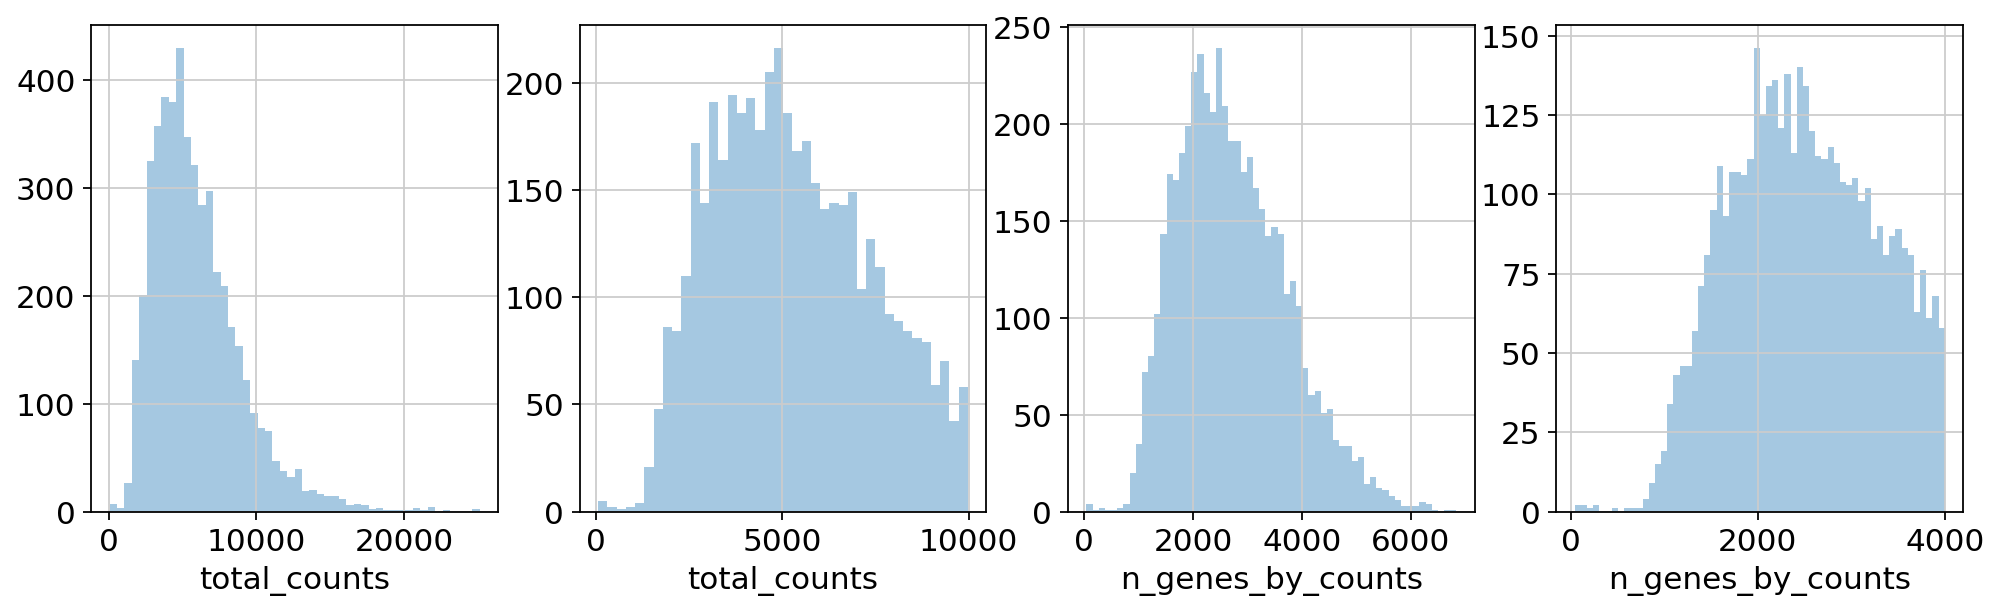

In [46]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

2nd graph: some dts that have 0 counts, but most of data lies between 1000-2000 counts


We'll use our histograms to apply some cutoffs to get rid of cells with abnormally low/large levels of gene expression.

In [47]:
#Gets rid of outliers

sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_cells(adata, max_counts=20000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

filtered out 7 cells that have less than 500 counts
filtered out 13 cells that have more than 20000 counts
#cells after MT filter: 4027
filtered out 18134 genes that are detected in less than 10 cells


/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


We proceed to normalize Visium counts data with the built-in `normalize_total` method from `Scanpy`, and detect highly-variable genes (for later).

In [48]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


##Clustering Gene Sets

To embed and cluster the manifold encoded by transcriptional similarity, we proceed as in the last notebook by making UMAP plots, and attempting to create clusters in state space based on common patterns of gene expression:

In [ ]:
!pip install leidenalg
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
computing PCA
    on highly variable genes
    with n_comps=50


In [ ]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

##Visualization in Spatial Coordinates

Let's now try and map the clusters we came up with back onto the original slice of the human brain:

In [ ]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

Before, we performed clustering in gene expression space, and visualized the results with UMAP. By visualizing clustered samples in spatial dimensions, we can gain insights into tissue organization and, potentially, into inter-cellular communication.

In [ ]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)

organization: each cluster shares a pattern of common gene expression. mapped like it is in layers
the way these cells organize into differnet layers, they make synaptic content of areas downstream of them


##Cluster Marker Genes

Let us further inspect cluster 5, which occurs along the middle of the image. We can pull out the marker genes for this cluster:

In [ ]:
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="5", n_genes=10, groupby="clusters")

top marker gene for cluster: FOS
gradient: gene expression
so a good marker gene would have more yellow color in one cluster andblue in other clusters 

And plot the top marker gene ('FOS') to see if its spatial expression pattern recapitulates the cluster's expression pattern:

In [ ]:
sc.pl.spatial(adata, img_key="hires", color=["clusters", "FOS"])

When you plot FOS, its a good marker gene bc it has good overlap between images. the yellow cluster is singularily plotted with with blue around it 


><b>Task:</b> Try all of this with "V1_Human_Brain_Section_2". Do you get different clusters? Try pulling out the top expressed genes for a couple of clusters - are they the same as in the first brain slice? Do you think that genetically-distinct neurons in the human brain are spatially organized? 

><b>Task:</b> Try the same thing with a section of the mouse brain - you can try "V1_Adult_Mouse_Brain_Coronal_Section_1", or "V1_Adult_Mouse_Brain_Coronal_Section_2". 

In [ ]:
#Trying w section 2
adata = sc.datasets.visium_sge(sample_id="V1_Adult_Mouse_Brain_Coronal_Section_1")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [ ]:

sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_cells(adata, max_counts=20000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

In [ ]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [ ]:
!pip install leidenalg
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

In [ ]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

In [ ]:
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="7", n_genes=10, groupby="clusters")

In [ ]:
sc.pl.spatial(adata, img_key="hires", color=["clusters", Dynll1"])

different cluster number but in the same place, 

In [ ]:
little squiggle is the dentae gyrus and its highly expressed